## Pytorch II:

We're going to continue where we left off from the first Pytorch tutorial, and explore more advanced topics such as pytorch datasets/dataloaders, the training loop, autograd, and how to define simple networks for the four main categories of task taught so far in the lectures:
1. Binary classification
2. Multi-label classification
3. Multi-class classification
4. Regression.

By the end we'll be able to build a simple Pytorch pipeline for each of these tasks.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np

!pip install -q torchinfo
from torchinfo import summary

### 0. Pytorch Dataset + Dataloader

In [ ]:
# Dummy Dataset
class SimpleDataset(Dataset):
    def __init__(self, task_type, num_samples=500, num_features=10):
        self.task_type = task_type
        self.num_samples = num_samples
        self.X = torch.rand(num_samples, num_features).to(torch.float32)  # 500 examples, 10 input features

        if task_type == 'binary classification':
            self.y = torch.randint(0, 2, size=(num_samples, 1)).to(torch.float32) # N x 1 binary label
        elif task_type == 'multi-class classification':
            self.y = torch.randint(0, 3, size=(num_samples,)).to(torch.int64)  # 3 classes
        elif task_type == 'multi-label classification':
            self.y = torch.randint(0, 2, size=(num_samples, 3)).to(torch.float32)  # 3 binary labels
        elif task_type == 'regression':
            self.y = torch.rand(num_samples, 1).to(torch.float32) # 1 continuous value
        else:
            print('Task not defined..')

        print('Size of dataset: X has shape {}, Y has shape {} and contains the following unique values {}'.format(self.X.shape, self.y.shape, self.y.unique()))

    def __len__(self):
        return self.num_samples

    # __getitem__ is responsible for fetching and returning a single sample from the dataset.
    # we can also add addition transforms here such as data augmentation
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
task = 'binary classification'

dataset = SimpleDataset(task)

In [ ]:
## How to iterate through examples in a dataset..

for i, (x, y) in enumerate(dataset):
  print('Example number {} -----'.format(i))
  print('Input features have shape {}, min value {:.2f}, max value {:.2f}'.format(x.shape, x.min(), x.max()))
  print('Labels for {} task, have shape {}, and contain the following value {}'.format(task, y.shape, y.unique()))
  #break

In [ ]:
## Lets split up our dataset into train, val and test datasets

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Can we set a random seed for the random_split method? https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

len(train_dataset), len(val_dataset), len(test_dataset)

train_dataset[0]

In [ ]:
## Now lets create a DataLoader. Dataset vs Dataloader ? Why do we need a DataLoader ?

# Dataset -> represents entire dataset, we can access examples one at a time.
# Dataloader -> wrapper for Dataset that enables efficient batch loading of data (mini-batching)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Why shuffle ?
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# How do we access data in the dataloaders ?

for i, (x, y) in enumerate(train_loader):
    print('Batch number {} -----'.format(i))
    print('Input features have shape {}, min value {:.2f}, max value {:.2f}'.format(x.shape, x.min(), x.max()))
    print('Labels for {} task, have shape {}, and contain the following value {}'.format(task, y.shape, y.unique()))
    break

### 1. Simple Multi-Layer Neural Network

In [ ]:
# Model
class SimpleMLP(nn.Module): # Multi-Layer Perceptron (MLP) == Feed Forward Network (FFN)
    def __init__(self, task_type):
        super(SimpleMLP, self).__init__()
        self.task_type = task_type
        # 'Linear' layer == 'Fully Connected' layer
        self.fc1 = nn.Linear(10, 64) # Layer 1
        self.fc2 = nn.Linear(64, 32) # Layer 2

        # Layer 3 (Prediction)
        if task_type == 'binary classification':
            self.fc3 = nn.Linear(32, 1)
        elif task_type == 'multi-class classification':
            self.fc3 = nn.Linear(32, 3)
        elif task_type == 'multi-label classification':
            self.fc3 = nn.Linear(32, 3)
        elif task_type == 'regression':
            self.fc3 = nn.Linear(32, 1)

    def forward(self, x):

        x = torch.relu(self.fc1(x)) # Linear -> ReLU
        x = torch.relu(self.fc2(x)) # Linear -> ReLU

        if self.task_type == 'binary classification':
            return torch.sigmoid(self.fc3(x)) # Linear -> Sigmoid

        elif self.task_type == 'multi-class classification':
            # Softmax required, but this is applied in CE loss
            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            return self.fc3(x)

        elif self.task_type == 'multi-label classification': # 3 x binary classification
            return torch.sigmoid(self.fc3(x)) # Apply sigmoid to each output

        elif self.task_type == 'regression':
            return torch.sigmoid(self.fc3(x)) # Do we always apply a sigmoid function for regression problems ?

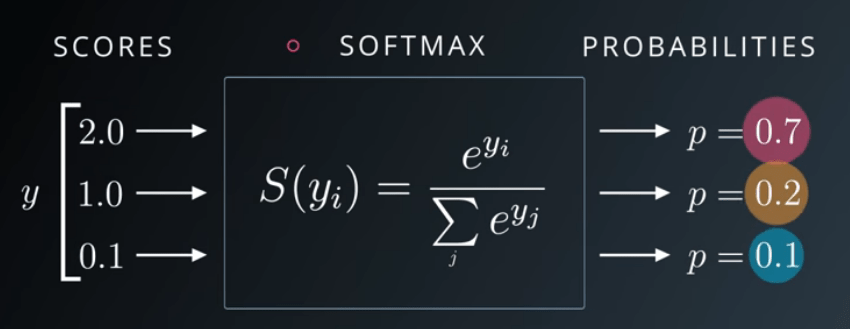

In [ ]:
# Print summary of model - very useful to verify and visualise layers
model = SimpleMLP(task_type='regression')

summary(model=model,
        input_size=(32, 10),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

### 2. Losses

In [ ]:
# Task Specific Adjustments
def get_criterion(task_type):
    if task_type == 'binary classification':
        return nn.BCELoss()
    elif task_type == 'multi-class classification':
        return nn.CrossEntropyLoss()
    elif task_type == 'multi-label classification':
        return nn.BCELoss()
    elif task_type == 'regression':
        return nn.MSELoss()
    else:
      print('No task defined')

In [ ]:
# Lets test BCE loss with some dummy inputs
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
bce_loss = get_criterion('binary classification')

# loss will accept a target of shape
pred = torch.randn(3, 1)
target = torch.rand(3, 1)

bce_loss(torch.sigmoid(pred), target)

In [ ]:
# Lets test CE loss with some dummy inputs
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
ce_loss = get_criterion('multi-class classification')

# loss will accept a target of shape
pred = torch.randn(4, 3)
target = torch.randint(0, 3, size=(4,)).to(torch.int64)

print(pred.shape, target.shape, target)

ce_loss(pred, target)

In [ ]:
# Lets test MSE loss with some dummy inputs
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
mse_loss = get_criterion('regression')

# loss will accept a target of shape
pred = torch.randn(3, 1)
target = torch.rand(3, 1)

mse_loss(pred, target)

### 3. Defining training and evaluation functions

In [ ]:
# Training Function
def train(model, dataloader, criterion, optimizer):
    # set model to training mode (turns on dropout, batch norm, enables gradient calculation)
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device) # Device? We can either use a CPU or GPU..
        optimizer.zero_grad() # resets (zeros) the gradients of all model parameters
        outputs = model(X) # forward pass
        loss = criterion(outputs, y) # calculate loss
        loss.backward() # backward pass, using gradient descent (torch's autograd method) to calculate gradients
        optimizer.step() # uses gradients to update model parameters.
        total_loss += loss.item()
    return total_loss / len(dataloader) # loss per batch

In [ ]:
# Evaluate Function
def evaluate(model, dataloader, criterion):
    # set model to evaluation mode (turn off dropout, deterministic behaviour)
    model.eval()
    total_loss = 0
    with torch.no_grad(): # disable all gradient calculations (saves memory)
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()
    return total_loss / len(dataloader)

### 4. The complete pipeline

In [ ]:
def run_pipeline(task_type):
    # Load dataset and create DataLoader
    dataset = SimpleDataset(task_type)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model, criterion, optimizer
    model = SimpleMLP(task_type).to(device)

    # Print summary of model - very useful to verify and visualise layers
    print(summary(model=model,
        input_size=(32, 10),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]))

    criterion = get_criterion(task_type)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Why Adam ?

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        # For every epoch we alternate between training on train data and evaluating on val data
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        # save model weights when we have the best val loss.

    # Test evaluation
    test_loss = evaluate(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Run Pipeline for each task
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # how to enable GPU in colab ?
print(device)

In [ ]:
# Q: should we expect the models to learn anything here?
tasks = ['binary classification', 'multi-class classification', 'multi-label classification', 'regression']
for task in tasks:
    print(f"\n--- Running pipeline for {task} task ---")
    run_pipeline(task)